In [1]:
import gzip
import json
import math
import numpy as np
import random
import sklearn
import string
from collections import defaultdict
from nltk.stem.porter import *
from sklearn import linear_model
import dateutil
from scipy.sparse import lil_matrix 

In [2]:
train_dataset, val_dataset, test_dataset = [],[],[]

# f = gzip.open("data/review-Hawaii_10.json.gz", mode="rt")

# for l in f.read():
#     d = eval(l)
#     dataset.append(d)
#     # if len(dataset) >= 20000:
#     #     break
        
# f.close()
with open("data/filter_all_t.json") as f:
    l = json.load(f)

In [3]:
l.keys()

dict_keys(['train', 'val', 'test'])

In [4]:
for d in l["train"]:
    train_dataset.append(d)

for d in l["val"]:
    val_dataset.append(d)

for d in l["test"]:
    test_dataset.append(d)
    
len(train_dataset), len(val_dataset), len(test_dataset)

(87013, 10860, 11015)

In [5]:
train_dataset[0]

{'business_id': '60567465d335d0abfb415b26',
 'user_id': '101074926318992653684',
 'rating': 4,
 'review_text': 'The tang of the tomato sauce is outstanding. And the crust is a meal, as it should be. Order a whole pie fresh.',
 'pics': ['AF1QipM-2IRmvitARbcJr7deWfe5hyVBg_ArPMQSYvq0',
  'AF1QipPWhe1OP80YPU40J6-XIdxbJIe57vKm8TTjve31',
  'AF1QipNuKWM65S9ZFQykvdIhKUliE6K1VBxssTUYyl8d',
  'AF1QipOJng1JS_1hmpfhAVrr7hE89dcoOtdy-Z6cOO9x'],
 'history_reviews': [['101074926318992653684_6056272797d555cc6fb0d147',
   'The pizza here is the real deal, perfect in every way except for the crust, which was more cracker crisp than chewy bread. Also recommend the meatball parmigiana hero, beefy, fluffy, overflowing, tangy, chunky tomato sauce, toothsome bread.'],
  ['101074926318992653684_604a65c2c6dc737bce7e5a3d',
   'Omg the tomato sauce is everything, in the meatball appetizer, pizza & as a dip for that scratch-made focaccia. Farm-fresh salad. A variety of artisan toppings. Ask for the chili oil! Goes

In [6]:
users = {}
business = {}
interactions = []

for d in train_dataset:
    if d["user_id"] not in users.keys(): users[d["user_id"]] = len(users)
    if d["business_id"] not in business.keys(): business[d["business_id"]] = len(business)
    interactions.append((d["user_id"], d["business_id"], d["rating"]))
    
len(users), len(business), len(interactions)

(29596, 27896, 87013)

In [7]:
random.shuffle(interactions)
mean_rating = sum([r for _,_,r in interactions])/len(interactions)

In [8]:
import math
import numpy as np
import random
import torch as torch
import torch.nn as nn
import time
from torch.utils.data import DataLoader, Dataset


In [9]:
class Brentford(nn.Module):
    
    def __init__(self, K, user_size,item_size):
        self.K = K
        self.beta_user = torch.from_numpy(np.random.normal(size=user_size)).type(dtype= torch.float32)
        self.beta_item = torch.from_numpy(np.random.normal(size=item_size)).type(dtype= torch.float32)
        self.gamma_user = torch.from_numpy(np.random.normal(size=(user_size,K))).type(dtype= torch.float32)
        self.gamma_item = torch.from_numpy(np.random.normal(size=(item_size,K))).type(dtype= torch.float32)
        self.alpha = torch.tensor([0.0]).type(dtype= torch.float32) ## zero initialization of alpha
        
        
        self.beta_user.requires_grad = True
        self.beta_item.requires_grad = True
        self.gamma_user.requires_grad = True
        self.gamma_item.requires_grad = True
        self.alpha.requires_grad = True
    
    def forward(self,bu,bi,gu,gi):
        
        return self.alpha + bu + bi+ torch.dot(gu, gi)
            
            
def train(model,lr,lam,train_set,users,items):
    
    device = None
    # check availability of gpu
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    print ("Running on: ", device)

    optimizer = torch.optim.SGD([model.beta_user, model.beta_item, model.gamma_user, model.gamma_item], lr= lr)
    ##criterion = nn.MSELoss()
    #model = model.to(device)
    #steps = len(train_set)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
    losses = []
    
    ts = time.time() 
    loss_tot = []
    for idx, (u,i,r) in enumerate(train_set):
        optimizer.zero_grad()
        
        beta_u = model.beta_user[users[u]]
        beta_i = model.beta_item[items[i]]
        gamma_u = model.gamma_user[users[u],:]
        gamma_i = model.gamma_item[items[i],:]
        
        # print(beta_u,beta_i,gamma_u,gamma_i)
        y = torch.tensor([float(r)])
        pred = model.forward(beta_u,beta_i,gamma_u,gamma_i)
        #loss = (pred-y)**2+lam*(torch.sum(model.beta_user)+\
        #       torch.sum(model.beta_item)+ torch.sum(torch.norm(model.gamma_user))+torch.sum(torch.norm(model.gamma_item)))
        
        loss = (pred-y)**2+lam*(beta_u+\
                beta_i+ torch.norm(gamma_u)+torch.norm(gamma_i))
        loss.backward()
        # model.beta_user[users[u]] -= lr*beta_u.grad
        # model.beta_item[items[i]] -= lr*beta_i.grad
        # model.gamma_user[users[u],:] -= lr*gamma_u.grad
        # model.gamma_item[items[i],:] -= lr*gamma_i.grad
        
        #print(model.beta_user[users[u]],model.beta_item[items[i]],model.gamma_user[users[u],:],model.gamma_item[items[i],:])
        optimizer.step()
        loss_tot.append(loss)
        if idx % 100 == 0:
                print("iter {}, loss: {}".format(idx, loss.item()))
                print(model.beta_user[users[u]],model.beta_item[items[i]],model.gamma_user[users[u],:],model.gamma_item[items[i],:])
                losses.append(torch.mean(torch.tensor(loss_tot)).item())
                loss_tot = []
    return losses

Consider Batching!

In [10]:
b_lfm = Brentford(2,len(users),len(business))

In [11]:
loss = train(b_lfm,0.01,0.001,interactions,users,business)

Running on:  cpu
iter 0, loss: 65.83424377441406
tensor(-0.2299, grad_fn=<SelectBackward0>) tensor(0.4477, grad_fn=<SelectBackward0>) tensor([1.9484, 0.7123], grad_fn=<SliceBackward0>) tensor([-1.0386,  0.1406], grad_fn=<SliceBackward0>)
iter 100, loss: 1.3383771181106567
tensor(0.7365, grad_fn=<SelectBackward0>) tensor(-0.3620, grad_fn=<SelectBackward0>) tensor([-0.4551, -1.7026], grad_fn=<SliceBackward0>) tensor([-1.2833, -1.8289], grad_fn=<SliceBackward0>)
iter 200, loss: 21.439716339111328
tensor(-1.2848, grad_fn=<SelectBackward0>) tensor(1.5079, grad_fn=<SelectBackward0>) tensor([ 0.1648, -0.0701], grad_fn=<SliceBackward0>) tensor([-1.8843,  0.1374], grad_fn=<SliceBackward0>)
iter 300, loss: 23.036314010620117
tensor(1.0879, grad_fn=<SelectBackward0>) tensor(1.1516, grad_fn=<SelectBackward0>) tensor([-0.0206,  1.1056], grad_fn=<SliceBackward0>) tensor([-0.7050, -1.3363], grad_fn=<SliceBackward0>)
iter 400, loss: 1.9282883405685425
tensor(1.2375, grad_fn=<SelectBackward0>) tensor(0

In [15]:
def test(model,test_set,users,items):
    predictions=[]
    labels = []
    loss_tot = []
    losses = []
    with torch.no_grad():
        for idx, (u,i,r) in enumerate(test_set):
            if u in users.keys() and i not in items.keys():
                beta_u = model.beta_user[users[u]]
                beta_i = model.beta_item[items[i]]
                gamma_u = model.gamma_user[users[u],:]
                gamma_i = model.gamma_item[items[i],:]
                pred = model.forward(beta_u,beta_i,gamma_u,gamma_i)
            else:
                pred = mean_rating   
            # print(beta_u,beta_i,gamma_u,gamma_i)
            y = torch.tensor([float(r)])
            
            #loss = (pred-y)**2+lam*(torch.sum(model.beta_user)+\
            #       torch.sum(model.beta_item)+ torch.sum(torch.norm(model.gamma_user))+torch.sum(torch.norm(model.gamma_item)))
            labels.append((y))
            predictions.append((u,i,pred))
            loss = (pred-y)**2
            
            loss_tot.append(loss)
            if idx % 100 == 0:
                #print("iter {}, loss: {}".format(idx, loss.item()))
                #print(model.beta_user[users[u]],model.beta_item[items[i]],model.gamma_user[users[u],:],model.gamma_item[items[i],:])
                losses.append(torch.mean(torch.tensor(loss_tot)).item())
                loss_tot = []
    return losses, predictions

In [16]:
# val_users = {}
# val_business = {}
val_interactions = []

for d in val_dataset:
    val_interactions.append((d["user_id"], d["business_id"], d["rating"]))
    
len(val_interactions)

test_users = {}
test_business = {}
test_interactions = []

for d in test_dataset:
    if d["user_id"] not in test_users.keys(): test_users[d["user_id"]] = len(test_users)
    if d["business_id"] not in test_business.keys(): test_business[d["business_id"]] = len(test_business)
    test_interactions.append((d["user_id"], d["business_id"], d["rating"]))


In [17]:
## testing the data
test_losses, test_precitions = test(b_lfm,test_interactions,users,business)

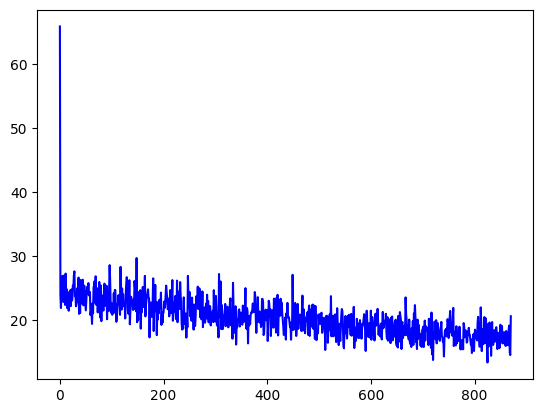

In [19]:
from matplotlib import pyplot as plt

## plot training losses
plt.plot(np.arange(len(loss)),loss,c="b")


In [20]:
metrics = {}

In [21]:
def MRR(predictions,users,items,k=3):
    userRanks = defaultdict(list)
    
    for (u,i,p) in predictions:
        userRanks[u].append((p,i))
        
    for u in userRanks:
        userRanks[u].sort(reverse=True)
        
    totalMRR = 0
    for u,preds in userRanks.items():
        rank = 0
        for i, (r,b) in enumerate(preds[:k]):
            if b in items and r >= 3:
                rank = i+1
                break
            
        if rank > 0:
            totalMRR += 1/rank
    
    return totalMRR/len(userRanks) if len(userRanks) > 0 else 0

In [22]:
mean_reciproal_rank = MRR(test_precitions,users,test_business)
mean_reciproal_rank
metrics["MRR"] = mean_reciproal_rank

In [23]:
mean_MSE =  sum(test_losses)/len(test_losses)
mean_MSE
metrics["average MSE"] = mean_MSE

In [24]:
def NDCG(predictions,labels,users,items,k=3):
    userRanks = defaultdict(list)
    labelRanks = defaultdict(list)
    
    for (u,i,p) in predictions:
        userRanks[u].append((p,i))
        
    for (u,i,p) in labels:
        labelRanks[u].append((p,i))
        
    for u in userRanks:
        userRanks[u].sort(reverse=True)
    
    for u in labelRanks:
        labelRanks[u].sort(reverse=True)
        
    totalDCG = 0
    for u,preds in userRanks.items():
        rank = 0
        rating = 0
        for i, (r,b) in enumerate(preds[:k]):
            if b in items and r >= 3:
                rank = i+1
                rating = r
                # break
                totalDCG += rating/np.log2(rank+1)
    
    totalIDCG = 0
    for u,preds in labelRanks.items():
        rank = 0
        rating = 0
        for i, (r,b) in enumerate(preds[:k]):
            if b in items and r >= 3:
                rank = i+1
                rating = r
                # break
                totalIDCG += rating/np.log2(rank+1)

    return totalDCG, totalDCG/totalIDCG

In [25]:
DCG3, NDCG3 = NDCG(test_precitions, test_interactions, test_users, test_business)
DCG3, NDCG3

metrics["NDCG"] = NDCG3

In [26]:
def Precision(predictions,labels,users,items,k=3):
    userRanks = defaultdict(list)
    labelRanks = defaultdict(list)
    
    for (u,i,p) in predictions:
        userRanks[u].append((p,i))
        
    for (u,i,p) in labels:
        labelRanks[u].append((p,i))
        
    for u in userRanks:
        userRanks[u].sort(reverse=True)
    
    for u in labelRanks:
        labelRanks[u].sort(reverse=True)
        
    totalPreKU = 0
    for u, preds in labelRanks.items():
        relevance = 0
        ps = [p[1] for p in userRanks[u][:k]]
        for i, (r,b) in enumerate(preds):
            if b in items and b in ps:
                relevance+=1
        totalPreKU += relevance/k

    return totalPreKU/len(users)

def Recall(predictions,labels,users,items,k=3):
    userRanks = defaultdict(list)
    labelRanks = defaultdict(list)
    
    for (u,i,p) in predictions:
        userRanks[u].append((p,i))
        
    for (u,i,p) in labels:
        labelRanks[u].append((p,i))
        
    for u in userRanks:
        userRanks[u].sort(reverse=True)
    
    for u in labelRanks:
        labelRanks[u].sort(reverse=True)
        
    totalRKU = 0
    for u, preds in labelRanks.items():
        relevance = 0
        ps = [p[1] for p in userRanks[u][:k]]
        for i, (r,b) in enumerate(preds):
            if b in items and b in ps:
                relevance+=1
        totalRKU += relevance/len(preds)

    return totalRKU/len(users)
                    

In [27]:
P3 = Precision(test_precitions,test_interactions,test_users,test_business)
P3
metrics["precision"] = P3

In [28]:
R3 = Recall(test_precitions,test_interactions, test_users, test_business)
R3
metrics["recall"] = R3

In [29]:
metrics

{'MRR': 1.0,
 'average MSE': 0.6785635481009612,
 'NDCG': 0.9698569094340085,
 'precision': 0.7966666666666425,
 'recall': 0.9159855047592548}